# Генеративно-состязательные сети


Попробуйте улучшить работу нейронной сети. Приложите анализ. Приложете лучшее сгенерированное изображение. Обратите внимание для запуска нейронной сети понадобиться tensorflow 2.1.0 и минимум 8gb опер. памяти(если запускать на процессоре).


## Подключение необходимых библиотек

In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git

    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
import tensorflow as tf
#tf.config.experimental.set_visible_devices([], 'GPU')

In [ ]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Предварительная обработка данных

Ссылка на датасет [здесь](https://www.tensorflow.org/datasets/datasets#cycle_gan). 

Нам необходимо конвертировать изображения в `286 x 286` и случайно выбранные из них обрезать до `256 x 256`.

Кроме этого мы перевернем изображения горизонтально, т.е. слева на право.

Таким образом мы проведем процедуру похожую на image augmentation.

In [ ]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteR5T09K/cycle_gan-trainA.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteR5T09K/cycle_gan-trainB.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteR5T09K/cycle_gan-testA.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteR5T09K/cycle_gan-testB.tfrecord
Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0. Subsequent calls will reuse this data.


In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [ ]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [ ]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [ ]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [ ]:
train_horses = train_horses.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

train_zebras = train_zebras.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

In [ ]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

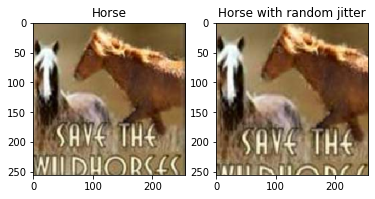

In [ ]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)

In [ ]:
plt.subplot(121)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Zebra with random jitter')
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)

## Импортирование  Pix2Pix модели

Генератор и дискриминатор мы возьмем из Pix2Pix модели, генерация будет осуществляться с применением Unet.

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [ ]:
generator_g.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 sequential (Sequential)        (None, None, None,   3072        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 sequential_1 (Sequential)      (None, None, None,   131328      ['sequential[0][0]']             
                                128)                                                          

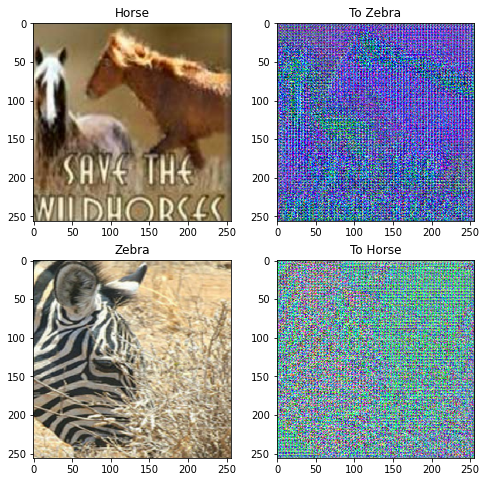

In [ ]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

## Loss functions

Loss функции для генератора и дискриминатора можно взять также из [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#define_the_loss_functions_and_the_optimizer).

In [ ]:
LAMBDA = 5

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

Инициализация оптимайзеров для всех генераторов и всех дискриминаторов.

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints

Сохранение промежуточных результатов, для того, чтобы при необходимости можно было продолжить обучение, а не начинать сначала.

In [ ]:
checkpoint_path = "./drive/MyDrive/Model"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, directory=checkpoint_path, max_to_keep=5)
# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


## Training

По умолчанию кол-во эпох выставлено 1 хотя, для корректного результатов понадобиться от нескольких десятков до нескольких сотен эпох.

In [ ]:
EPOCHS = 35

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

Несмотря на то, что тренировочный процесс у GAN более сложный, он состоит из тех же этапов, что обычно:

* Получить предсказание
* Вычислить ошибку
* Посчитать градиенты используя обратное распространения ошибки.
* Применить градиенты для оптимайзера.

In [ ]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.
        
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        
        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
    
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                            generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                            generator_f.trainable_variables)
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                                discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                                discriminator_y.trainable_variables)
    
    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                                generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                                generator_f.trainable_variables))
    
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                    discriminator_x.trainable_variables))
    
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                    discriminator_y.trainable_variables))

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
        train_step(image_x, image_y)
        if n % 10 == 0:
            print ('.', end='')
        n+=1

    clear_output(wait=True)
    # Using a consistent image (sample_horse) so that the progress of the model
    # is clearly visible.
    generate_images(generator_g, sample_horse)

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                            ckpt_save_path))

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

Saving checkpoint for epoch 5 at ./drive/MyDrive/Model/ckpt-3
Time taken for epoch 5 is 468.71927094459534 sec



## Generate using test dataset

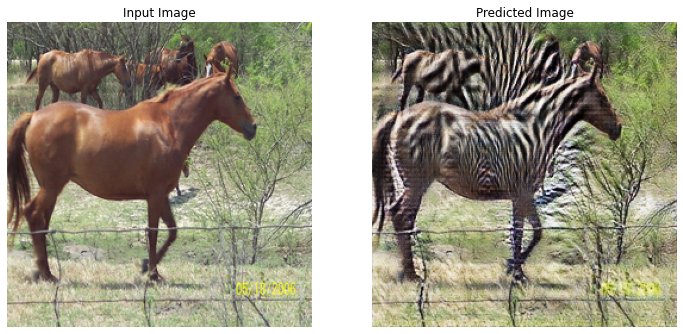

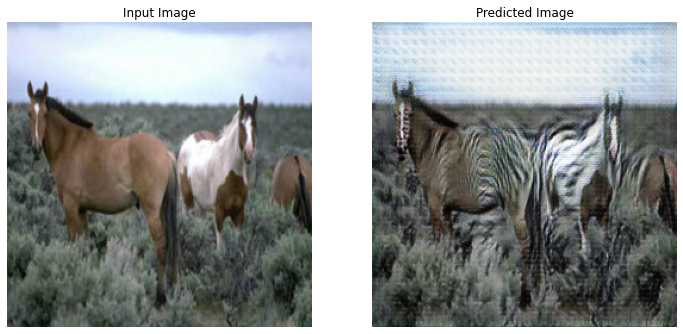

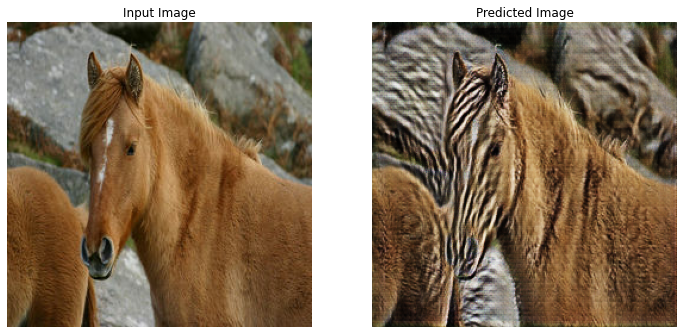

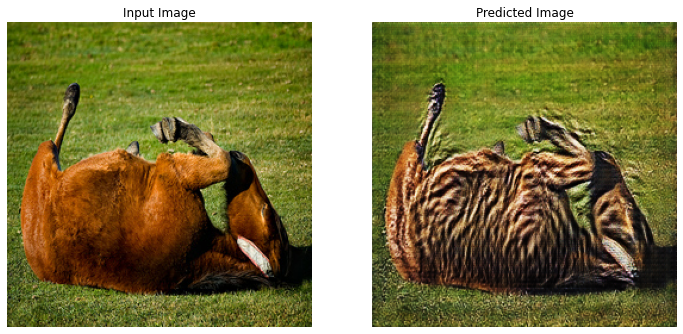

In [ ]:
# Run the trained model on the test dataset
for inp in test_horses.take(5):
  generate_images(generator_g, inp)

# Практическое задание к курсу


1.   Обучите нейронную сеть любой архитектуры которой не было на курсе, либо обучите нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ, того, что вам помогло в улучшения работы нейронной сети.
    

*   вариант для 1) Обучите VAE на fashion_mnist 
*   вариант для 1) Обучите GAN на одном классе CIFAR
*   вариант для 1) обучите классификатор на данных tfds (Kaggle, UCI)
*   вариант для 1) обучите семантическую сегментацию на tfds (Kaggle, UCI)

   
2.    Сделайте краткий обзор какой-нибудь научной работы посвященной тому или иному алгоритму нейронных сетей, который не рассматривался на 
курсе. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике? 
>

In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Concatenate, Lambda, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers, activations
from tensorflow.keras.utils import to_categorical, plot_model 

from sklearn.metrics import (precision_score, f1_score, accuracy_score, \
                            recall_score, classification_report, \
                            confusion_matrix, ConfusionMatrixDisplay)

import matplotlib.pyplot as plt
#import itertools
#import shutil
%matplotlib inline

### Model Inception-Resnet-V2 

Очень глубокие сверточные сети сыграли центральную роль в крупнейших достижениях в производительности распознавания изображений. Одним из примеров является архитектура SOTA, которая, как было показано, обеспечивает очень хорошую производительность при относительно низких вычислительных затратах.

Inception-ResNet-v2 сверточная нейронная сеть (CNN), которая достигает нового уровня техники с точки зрения точности в тесте классификации изображений ILSVRC. Inception-ResNet-v2 - это вариант модели Inception V3, которая заимствует некоторые идеи из документов Microsoft ResNet. 
Inception-ResNet-V2 объединяет две архитектуры для дальнейшего повышения производительности.

Residual Inception blocks позволили исследователям успешно обучать еще более глубокие нейронные сети, что привело к еще большей производительности. Что также позволило значительно упростить начальные блоки.

<h3>Принципиальная схема Inception-Resnet-V2</h3>

![](http://yeephycho.github.io/blog_img/Inception_ResNet_v2.jpg)

In [2]:
# Convolutional Block
def conv2d(x,numfilt,filtsz,strides=1,pad='same',act=True,name=None):
    x = Conv2D(numfilt,filtsz,strides,padding=pad,data_format='channels_last',use_bias=False,name=name+'conv2d')(x)
    x = BatchNormalization(axis=3,scale=False,name=name+'conv2d'+'bn')(x)
    if act:
        x = Activation('relu',name=name+'conv2d'+'act')(x)
    return x

# Inception ResNet A block
def incresA(x,scale,name=None):
    pad = 'same'
    branch0 = conv2d(x,32,1,1,pad,True,name=name+'b0')
    branch1 = conv2d(x,32,1,1,pad,True,name=name+'b1_1')
    branch1 = conv2d(branch1,32,3,1,pad,True,name=name+'b1_2')
    branch2 = conv2d(x,32,1,1,pad,True,name=name+'b2_1')
    branch2 = conv2d(branch2,48,3,1,pad,True,name=name+'b2_2')
    branch2 = conv2d(branch2,64,3,1,pad,True,name=name+'b2_3')
    branches = [branch0,branch1,branch2]
    mixed = Concatenate(axis=3, name=name + '_concat')(branches)
    filt_exp_1x1 = conv2d(mixed,384,1,1,pad,False,name=name+'filt_exp_1x1')
    final_lay = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
                      output_shape=backend.int_shape(x)[1:],
                      arguments={'scale': scale},
                      name=name+'act_scaling')([x, filt_exp_1x1])
    return final_lay

# Inception ResNet B block
def incresB(x,scale,name=None):
    pad = 'same'
    branch0 = conv2d(x,192,1,1,pad,True,name=name+'b0')
    branch1 = conv2d(x,128,1,1,pad,True,name=name+'b1_1')
    branch1 = conv2d(branch1,160,[1,7],1,pad,True,name=name+'b1_2')
    branch1 = conv2d(branch1,192,[7,1],1,pad,True,name=name+'b1_3')
    branches = [branch0,branch1]
    mixed = Concatenate(axis=3, name=name + '_mixed')(branches)
    filt_exp_1x1 = conv2d(mixed,1152,1,1,pad,False,name=name+'filt_exp_1x1')
    final_lay = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
                      output_shape=backend.int_shape(x)[1:],
                      arguments={'scale': scale},
                      name=name+'act_scaling')([x, filt_exp_1x1])
    return final_lay

# Inception ResNet C block
def incresC(x,scale,name=None):
    pad = 'same'
    branch0 = conv2d(x,192,1,1,pad,True,name=name+'b0')
    branch1 = conv2d(x,192,1,1,pad,True,name=name+'b1_1')
    branch1 = conv2d(branch1,224,[1,3],1,pad,True,name=name+'b1_2')
    branch1 = conv2d(branch1,256,[3,1],1,pad,True,name=name+'b1_3')
    branches = [branch0,branch1]
    mixed = Concatenate(axis=3, name=name + '_mixed')(branches)
    filt_exp_1x1 = conv2d(mixed,2048,1,1,pad,False,name=name+'fin1x1')
    final_lay = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
                      output_shape=backend.int_shape(x)[1:],
                      arguments={'scale': scale},
                      name=name+'act_saling')([x, filt_exp_1x1])
    return final_lay

In [3]:
# Stem block
img_input = Input(shape=(32,32,3))
num_classes = 10

x = Conv2DTranspose(3, (2, 2), strides = (2, 2), padding = 'same', name='conv0')(img_input)
x = conv2d(x,32,3,2,'valid',True,name='conv1')
x = conv2d(x,32,3,1,'valid',True,name='conv2')
x = conv2d(x,64,3,1,'valid',True,name='conv3')

x_11 = MaxPooling2D(3,strides=1,padding='valid',name='stem_br_11'+'_maxpool_1')(x)
x_12 = conv2d(x,64,3,1,'valid',True,name='stem_br_12')

x = Concatenate(axis=3, name = 'stem_concat_1')([x_11,x_12])

x_21 = conv2d(x,64,1,1,'same',True,name='stem_br_211')
x_21 = conv2d(x_21,64,[1,7],1,'same',True,name='stem_br_212')
x_21 = conv2d(x_21,64,[7,1],1,'same',True,name='stem_br_213')
x_21 = conv2d(x_21,96,3,1,'valid',True,name='stem_br_214')

x_22 = conv2d(x,64,1,1,'same',True,name='stem_br_221')
x_22 = conv2d(x_22,96,3,1,'valid',True,name='stem_br_222')

x = Concatenate(axis=3, name = 'stem_concat_2')([x_21,x_22])

x_31 = conv2d(x,192,3,1,'valid',True,name='stem_br_31')
x_32 = MaxPooling2D(3,strides=1,padding='valid',name='stem_br_32'+'_maxpool_2')(x)
x = Concatenate(axis=3, name = 'stem_concat_3')([x_31,x_32])

In [4]:
# Inception-ResNet Network
#Inception-ResNet-A modules
x = incresA(x,0.15,name='incresA_1')
x = incresA(x,0.15,name='incresA_2')
x = incresA(x,0.15,name='incresA_3')
x = incresA(x,0.15,name='incresA_4')

#35 × 35 to 17 × 17 reduction module.
x_red_11 = MaxPooling2D(3,strides=2,padding='valid',name='red_maxpool_1')(x)

x_red_12 = conv2d(x,384,3,2,'valid',True,name='x_red1_c1')

x_red_13 = conv2d(x,256,1,1,'same',True,name='x_red1_c2_1')
x_red_13 = conv2d(x_red_13,256,3,1,'same',True,name='x_red1_c2_2')
x_red_13 = conv2d(x_red_13,384,3,2,'valid',True,name='x_red1_c2_3')

x = Concatenate(axis=3, name='red_concat_1')([x_red_11,x_red_12,x_red_13])

#Inception-ResNet-B modules
x = incresB(x,0.1,name='incresB_1')
x = incresB(x,0.1,name='incresB_2')
x = incresB(x,0.1,name='incresB_3')
x = incresB(x,0.1,name='incresB_4')
x = incresB(x,0.1,name='incresB_5')
x = incresB(x,0.1,name='incresB_6')
x = incresB(x,0.1,name='incresB_7')

#17 × 17 to 8 × 8 reduction module.
x_red_21 = MaxPooling2D(3,strides=2,padding='valid',name='red_maxpool_2')(x)

x_red_22 = conv2d(x,256,1,1,'same',True,name='x_red2_c11')
x_red_22 = conv2d(x_red_22,384,3,2,'valid',True,name='x_red2_c12')

x_red_23 = conv2d(x,256,1,1,'same',True,name='x_red2_c21')
x_red_23 = conv2d(x_red_23,256,3,2,'valid',True,name='x_red2_c22')

x_red_24 = conv2d(x,256,1,1,'same',True,name='x_red2_c31')
x_red_24 = conv2d(x_red_24,256,3,1,'same',True,name='x_red2_c32')
x_red_24 = conv2d(x_red_24,256,3,2,'valid',True,name='x_red2_c33')

x = Concatenate(axis=3, name='red_concat_2')([x_red_21,x_red_22,x_red_23,x_red_24])

#Inception-ResNet-C modules
x = incresC(x,0.2,name='incresC_1')
x = incresC(x,0.2,name='incresC_2')
x = incresC(x,0.2,name='incresC_3')

#TOP
x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dropout(0.6)(x)
x = Dense(num_classes, activation='softmax')(x)

In [5]:
# Building the model
model = Model(img_input, x, name='inception_resnet_v2')

In [21]:
# Model Summary
keras.utils.plot_model(model, show_shapes=True)
#model.summary()

In [7]:
# Configure the Model for training
model.compile(Adam(), 
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [9]:
from tensorflow.keras.datasets import cifar10

# разделение тренировочной и тестовой выборки
(x_train, y_train), (x_test, y_test_) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'тренировочные примеры')
print(x_test.shape[0], 'тестовые примеры')

# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test_, num_classes)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

170508288/170498071 [==============================] - 6s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


In [10]:
epochs = 15
batch_size = 128

# Training the Model
with tf.device("GPU:0"):
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              workers=-1,
              verbose=1)

Epoch 1/15
391/391 [==============================] - 310s 737ms/step - loss: 1.7726 - accuracy: 0.4314 - val_loss: 2.5681 - val_accuracy: 0.1673
Epoch 2/15
391/391 [==============================] - 283s 724ms/step - loss: 1.1327 - accuracy: 0.6218 - val_loss: 1.1361 - val_accuracy: 0.6048
Epoch 3/15
391/391 [==============================] - 284s 726ms/step - loss: 0.8600 - accuracy: 0.7065 - val_loss: 0.8291 - val_accuracy: 0.7056
Epoch 4/15
391/391 [==============================] - 283s 724ms/step - loss: 0.6751 - accuracy: 0.7669 - val_loss: 0.7571 - val_accuracy: 0.7399
Epoch 5/15
391/391 [==============================] - 283s 723ms/step - loss: 0.5543 - accuracy: 0.8088 - val_loss: 0.7235 - val_accuracy: 0.7535
Epoch 6/15
391/391 [==============================] - 283s 723ms/step - loss: 0.4750 - accuracy: 0.8379 - val_loss: 0.7110 - val_accuracy: 0.7748
Epoch 7/15
391/391 [==============================] - 283s 723ms/step - loss: 0.4034 - accuracy: 0.8603 - val_loss: 0.5541 -

In [11]:
scores = model.evaluate(x_test, y_test, verbose=1)
print(f'Test loss: {scores[0]:.4f}')
print(f'Test accuracy: {scores[1]*100:.2f} %')

313/313 [==============================] - 19s 58ms/step - loss: 0.5840 - accuracy: 0.8492
Test loss: 0.5840
Test accuracy: 84.92 %


####Посмотрим на точность нашей обученной нейронной сети:

In [12]:
predictions = model.predict(x_test)
y_pred = np.argmax(predictions,axis=1)

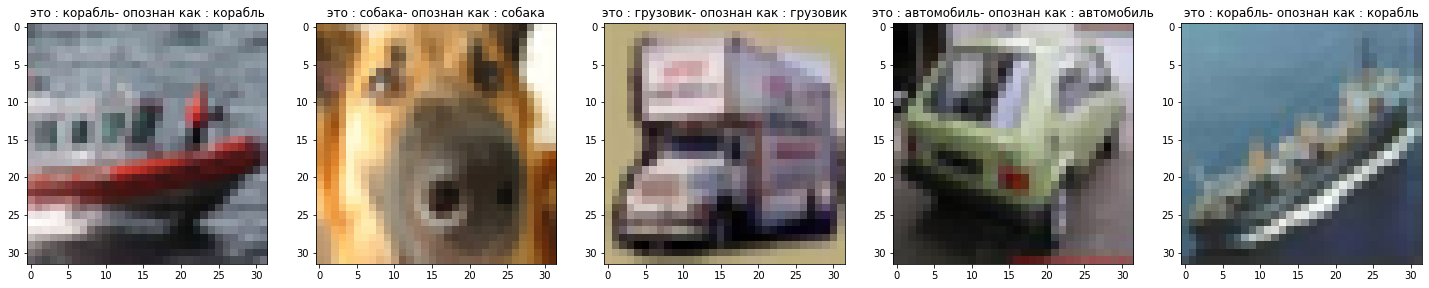

In [20]:
rng = np.random.default_rng()

N = rng.integers(10000, size=5)
number =150
plt.figure(figsize=(25, 25))

for i in N:
    y_t = np.argmax(y_test[i:i+1], axis = 1 )
    y_i = np.argmax(predictions[i:i+1], axis = 1 )
    number += 1
    plt.subplot(number)
    plt.imshow(x_test[i][:,:,:])
    plt.title('это : '+classes[y_t[0]]+'- опознан как : '+classes[y_i[0]])
plt.show()

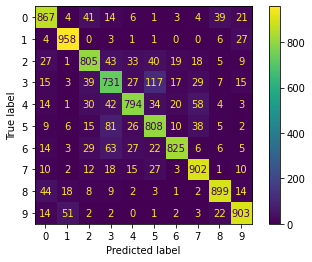

In [15]:
CM = confusion_matrix(y_test_,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=np.arange(10))
disp.plot( values_format ='.3g')
plt.show()

In [16]:
def Accuracy_model(test, predict):
    test = test.T
    predict = to_categorical(predict).T
    Accuracy = pd.DataFrame(columns=['Classes', 'Accuracy', 'Precision', 'Recall', 'f1-score'])
    Accuracy['Classes']= ['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']
    Accuracy['Accuracy'] = [ np.around(accuracy_score(test[i], predict[i])*100, 2) for i in range(10)]
    Accuracy['Precision'] = [ np.around(precision_score(test[i], predict[i])*100, 2) for i in range(10)]
    Accuracy['Recall'] = [ np.around(recall_score(test[i], predict[i])*100, 2) for i in range(10)]
    Accuracy['f1-score'] = [ np.around(f1_score(test[i], predict[i])*100, 2) for i in range(10)]
    
    return Accuracy

In [17]:
Accuracy_model(y_test, y_pred)

Classes  Accuracy  Precision  Recall  f1-score
0     самолет     97.16      85.17    86.7     85.93
1  автомобиль     98.69      91.50    95.8     93.60
2       птица     96.29      82.06    80.5     81.27
3         кот     94.56      72.66    73.1     72.88
4       олень     96.57      85.28    79.4     82.24
5      собака     95.62      76.66    80.8     78.68
6     лягушка     97.50      91.67    82.5     86.84
7      лошадь     97.44      85.09    90.2     87.57
8     корабль     98.04      90.44    89.9     90.17
9    грузовик     97.97      89.49    90.3     89.90